# Introduction to Active Learning with modAL

This tutorial is based on the official documentation. For more information click [here](https://modal-python.readthedocs.io/en/latest/content/overview/modAL-in-a-nutshell.html) to get to the official website.

This tutorial is about introducing you to the concept of active learning through first steps with the *modAL* package.

Here you will learn to:
- write a simple active learning sampling strategy
- utilize the defined sampling strategy as part of the *modAL* package

**modAL** is an active learning framework for Python3, designed with modularity, flexibility and extensibility in mind. Built on top of scikit-learn, it allows you to rapidly create active learning workflows with nearly complete freedom. What is more, you can easily replace parts with your custom built solutions, allowing you to design novel algorithms with ease.

With the recent explosion of available data, you have can have millions of unlabelled examples with a high cost to obtain labels. For instance, when trying to predict the sentiment of tweets, obtaining a training set can require immense manual labour. But worry not, active learning comes to the rescue! In general, AL is a framework allowing you to increase classification performance by intelligently querying you to label the most informative instances.

## Installation

To install modAL you can use this command which will install the package directly from source:

`%pip install git+https://github.com/modAL-python/modAL.git`

(Remove `%` if you are running this command from your terminal or from a .py-file)

In [1]:
#%pip install git+https://github.com/modAL-python/modAL.git

## modAL in action

Active learning with a scikit-learn classifier, for instance RandomForestClassifier, can be as simple as the following.

```
from modAL.models import ActiveLearner
from sklearn.ensemble import RandomForestClassifier

# initializing the learner
learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    X_training=X_training, y_training=y_training
)

# query for labels
query_idx, query_inst = learner.query(X_pool)

# ...obtaining new labels from the Oracle...

# supply label for queried instance
learner.teach(X_pool[query_idx], y_new)
```

### An example with active regression

To see modAL in real action, let’s consider an active regression problem with Gaussian processes! In this example, we shall try to learn a noisy sine function.

Let's define our dataset with the inputs `X` and the outputs `Y`

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# training data
value_range = (0, 20)
x_allowed = np.linspace(*value_range, 1000).reshape(-1, 1)
ground_truth = lambda x: np.sin(x) + np.random.normal(scale=0.3, size=x.shape)

For active learning, we shall define a custom query strategy tailored to Gaussian processes. In a nutshell, a *query stategy* in modAL is a function taking (at least) two arguments (an estimator object and a pool of examples), outputting the index of the queried instance and the instance itself. In our case, the arguments are `regressor` and `X`.

In [3]:
def GP_regression_std(regressor, X, n_instances=1):
    
    _, std = regressor.predict(X.reshape(-1, 1), return_std=True)  # for a Gaussian process estimator, we get the standard deviation easily
    # get the n_instances indices with the highest standard deviation
    query_idx = np.argsort(std)[-n_instances:]    
    return query_idx, X[query_idx]

After setting up the query strategy and the data, the active learner can be initialized.

In [4]:
from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

n_initial = 5  # initial amount of random samples

# get initial training data - random samples
# initial_idx = np.random.choice(range(len(x_training)), size=n_initial, replace=False)  # draw random initial indices
# x_training_init, y_training_init = x_training[initial_idx], y_training[initial_idx]  # set the initial training data
x_initial = np.random.uniform(*value_range, (n_initial, 1))
y_initial = ground_truth(x_initial)

# define a kernel for the Gaussian process regressor
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# initialize the regressor and train it with the initial training data
regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=x_initial, y_training=y_initial
)

x_querried = np.array(x_initial)
y_querried = np.array(y_initial)

Let's check how well the estimator is fitted by first defining a plotting function and then calling it

In [5]:
from sklearn.metrics import mean_squared_error

# plotting method which we can reuse later
def plotting_method(regressor, x, x_true=None, y_true=None, mse=None, x_new=None, x_querried=None, y_querried=None, return_std_available=True):
    if return_std_available:
        y, y_std = regressor.predict(x, return_std=True)
    else:
        y = regressor.predict(x).reshape(-1,)
        y_std = np.zeros_like(y)
        
    plt.figure(figsize=(10, 5))
    plt.plot(x[:, -1], y, label='Prediction')
    plt.fill_between(x[:, -1], y - y_std, y + y_std, alpha=0.2)
    if x_true is not None and y_true is not None:
        plt.scatter(x_true, y_true, c='grey', s=20, label='Training samples')
    if x_new is not None:
        # make a vertical line to indicate the new training sample
        if isinstance(x_new, (int, float)):
            x_new = [x_new]
        for x in x_new:
            plt.axvline(x=x, c='r', linestyle='--')
    if x_querried is not None and y_querried is not None:
        plt.plot(x_querried, y_querried, 'x', color='red', label='Querried samples')
    if mse is not None:
        plt.title(f'Prediction over the whole grid (mse={np.round(mse, 4)})')
    else:
        plt.title('Prediction')
    
    plt.legend()
    plt.show()

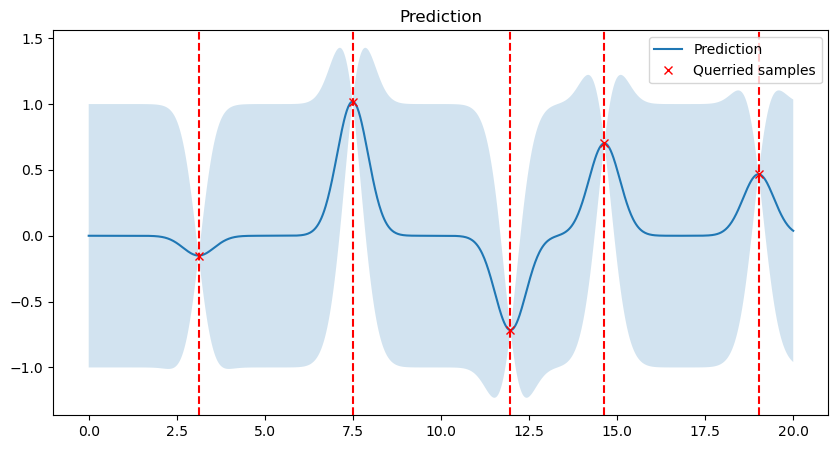

In [6]:
# get querried y-values
plotting_method(regressor, x_allowed, x_new=x_initial, x_querried=x_querried, y_querried=y_querried)

The blue band enveloping the regressor represents the standard deviation of the Gaussian process at the given point. 

Now we are ready to do active learning!

In [7]:
n_queries = 1

_, x_new = regressor.query(x_allowed, n_instances=n_queries)  # get the query points from the regressor which are expected to be the most informative
x_new = x_new.reshape(-1, 1)
y_new = ground_truth(x_new)

regressor.teach(x_new, y_new)  # fit the model with the query points

x_querried = np.concatenate((x_querried, x_new))
y_querried = np.concatenate((y_querried, y_new))


Let's check if the regressor benefited from the query

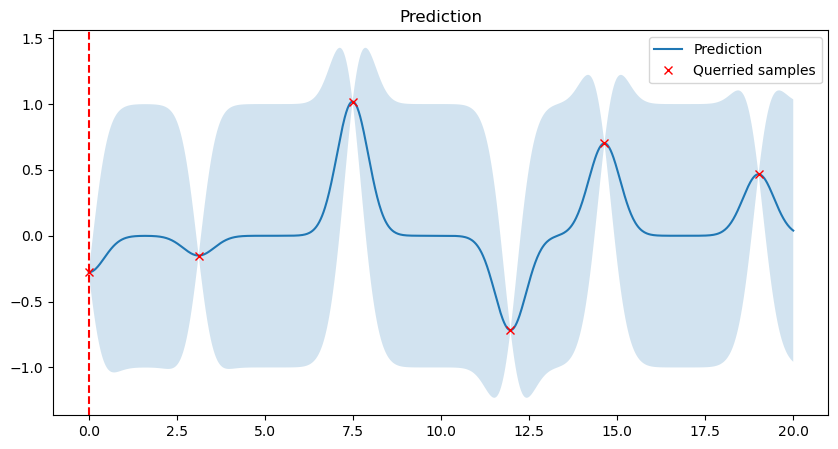

In [8]:
# get the predicted response and the standard deviation
y_pred, y_std = regressor.predict(x_allowed, return_std=True)

plotting_method(regressor, x_allowed, x_new=x_new, x_querried=x_querried, y_querried=y_querried)

Does it look already any better?

What happened from the initial plot to the second one?

Let's iterate a few more times and check the result after each iteration!

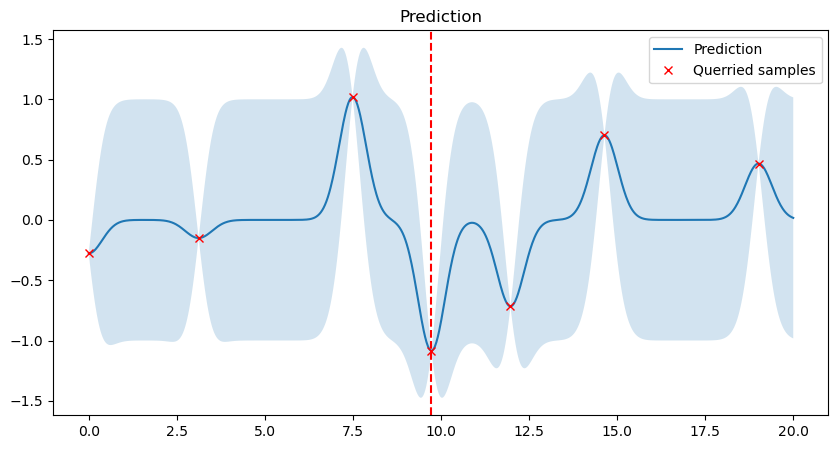

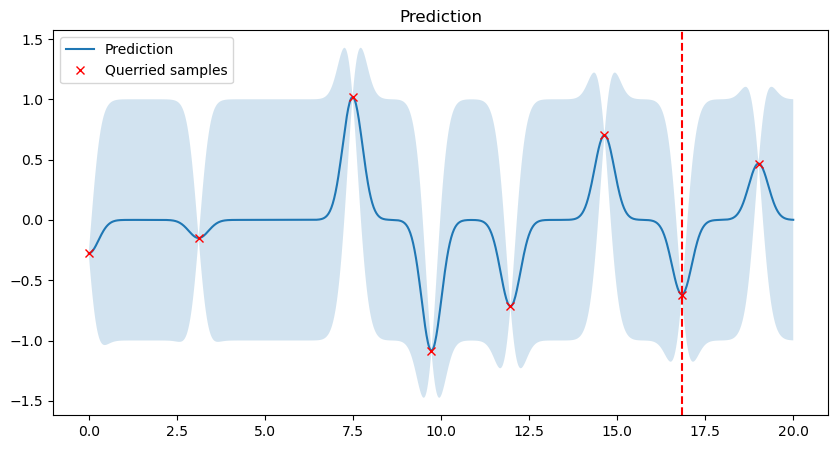

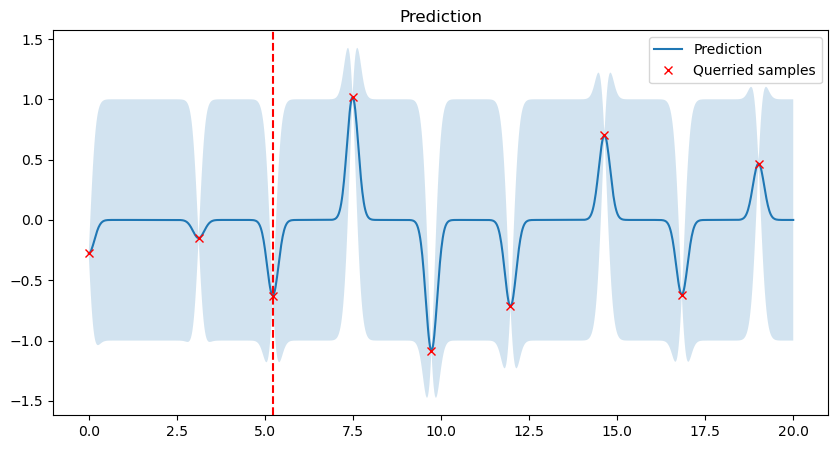

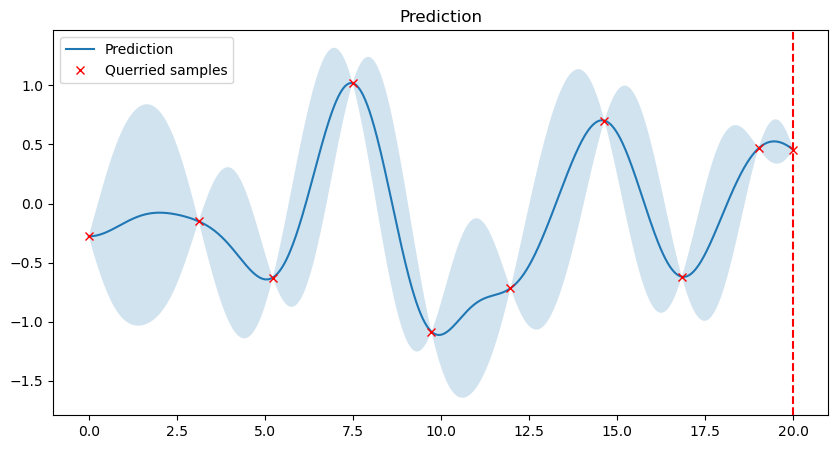

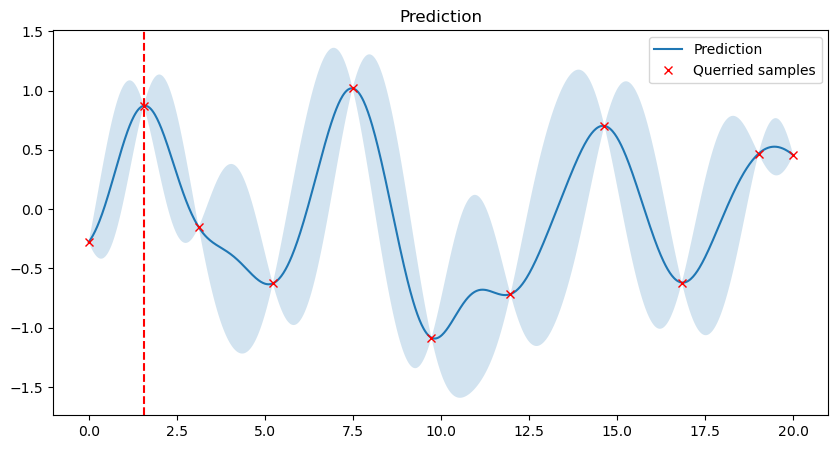

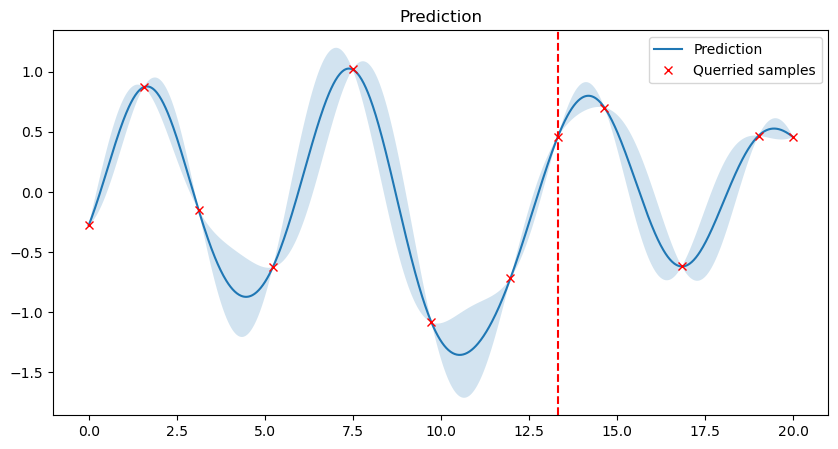

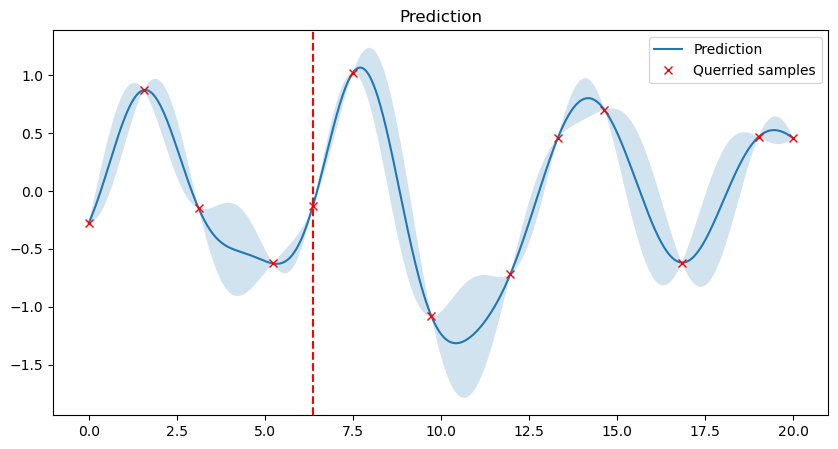

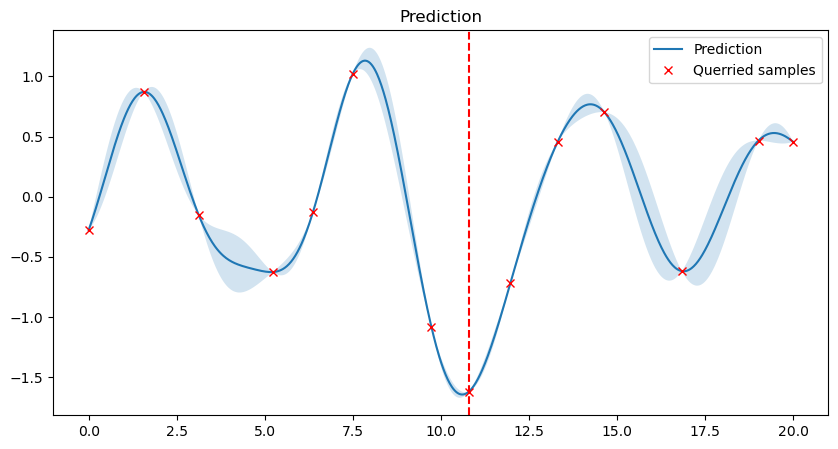

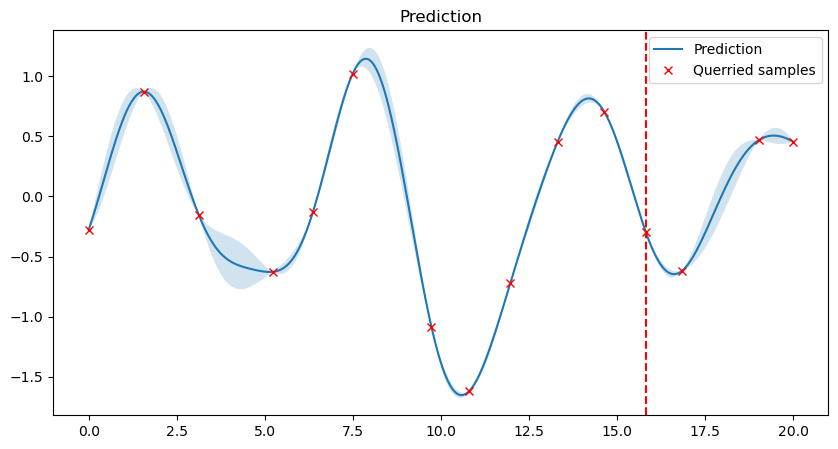

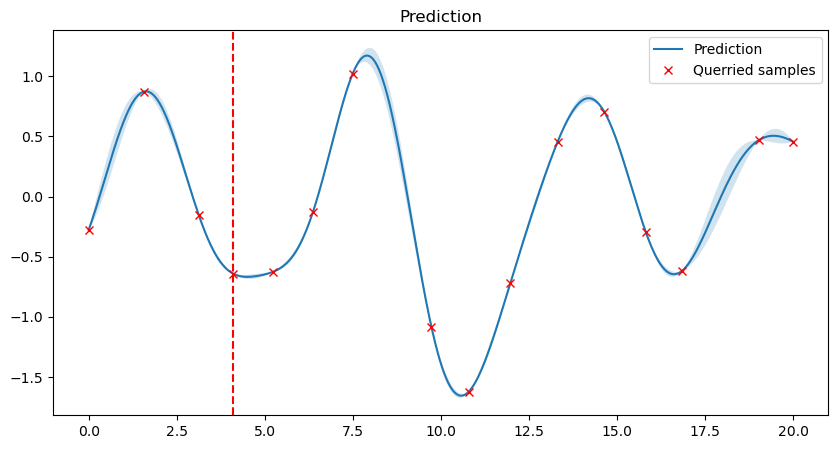

In [9]:
iterations = 10

for _ in range(iterations):
    x_new = regressor.query(x_allowed, n_instances=n_queries)[1].reshape(-1, 1)  # get the query points from the regressor which are expected to be the most informative
    y_new = ground_truth(x_new)
    regressor.teach(x_new, y_new)  # fit the model with the query points
    
    x_querried = np.concatenate((x_querried, x_new))
    y_querried = np.concatenate((y_querried, y_new))
    
    # get the predicted response and the standard deviation
    y_pred, y_std = regressor.predict(x_allowed, return_std=True)
    # y_pred, y_std = y_pred.ravel(), y_std.ravel()

    plotting_method(regressor, x_allowed, x_new=x_new, x_querried=x_querried, y_querried=y_querried)

### Let's train the same model with a random sampling method

Now we implement a simple random sampling method and give it directly the amount of training samples which we gave to the active learning algorithm.

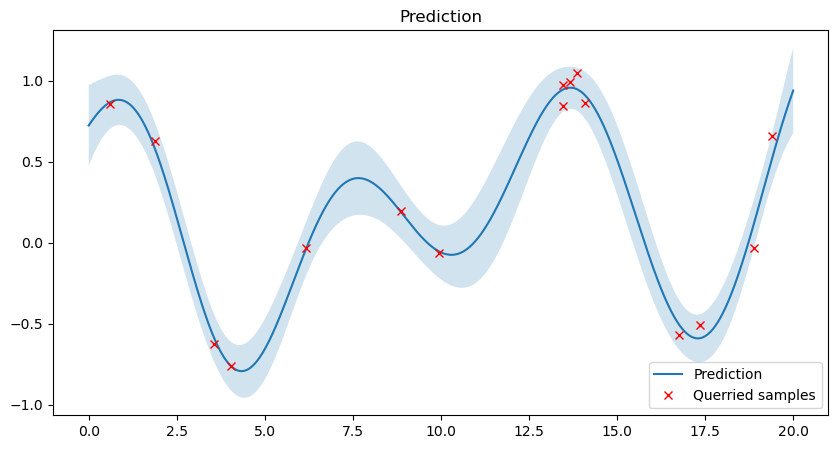

In [23]:
n_random_points = n_initial + (1+iterations)*n_queries

# get a training set of random points and evaluate the regression
x_random = np.random.uniform(*value_range, (n_random_points, 1))
y_random = ground_truth(x_random)

regressor_rnd = GaussianProcessRegressor(kernel=kernel)  # initialize the same regressor as for the active learner
regressor_rnd.fit(x_random, y_random)  # fit the regressor to the random data

plotting_method(regressor_rnd, x_allowed, x_querried=x_random, y_querried=y_random)

### Now let's compare these two models against the true data

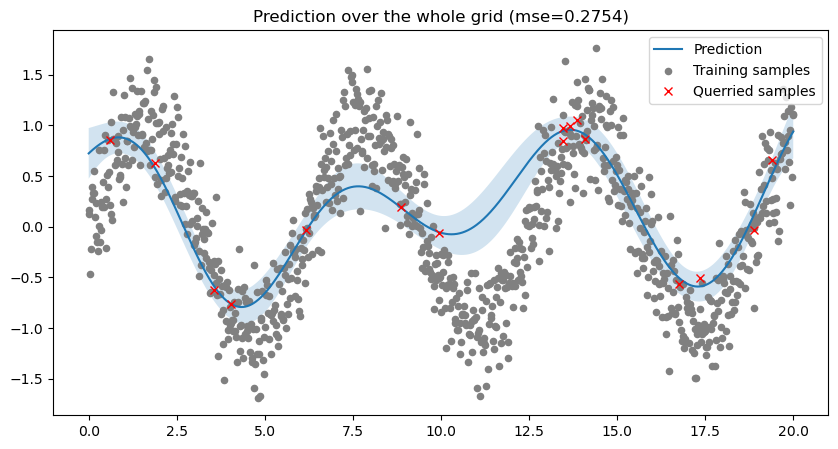

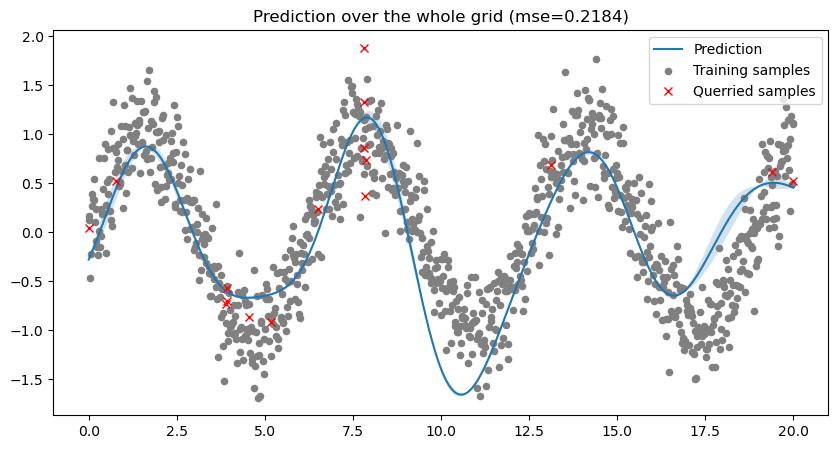

In [24]:
x_true = x_allowed
y_true = ground_truth(x_true)

y_al = regressor.predict(x_true)
y_rnd = regressor_rnd.predict(x_true)

mse_al = mean_squared_error(y_true, y_al)
mse_rnd = mean_squared_error(y_true, y_rnd)

plotting_method(regressor_rnd, x_allowed, x_true=x_true, y_true=y_true, mse=mse_rnd, x_querried=x_random, y_querried=y_random)
plotting_method(regressor, x_allowed, x_true=x_true, y_true=y_true, mse=mse_al, x_querried=x_querried, y_querried=y_querried)

How does the estimator with random sampling perform compared to active learning?

Can you explain the results by looking step-by-step at the chosen samples by the active learning algorithm?

Try and increase the noise bit-by-bit e.g., in steps of 0.2 and re-run the code.

What happens hereby?

## Active learning with the FFNRegressor

In this section we will replace the `GaussianProcessRegressor` with our `FFNRegressor`.

Unlike the `GaussianProcessRegressor`, the `FFNRegressor` does not provide any estimation of the standard deviation, i.e. we do not get an uncertainty measure. Fortunately, modAL has a solution for that!

This solution is called **Committee** or **Ensemble**. An ensemble carries several initializations of the same type of model.
The uncertainty is estimated based on the degree of **Disagreement** between the models for the same conditions, i.e. if we provide the ensemble with the two conditions `X=1` and `X=2` we would get e.g. `(0.8, 0.34, 0.67, 0.98) = ensemble(X=1)` and `(1.31, 1.34, 1.47, 1.28) = ensemble(X=2)`, respectively. By computing the variance of the predictions, we can tell for which condition the ensemble is more uncertain - in this case for condition `X=1`. Therefore, we would querry a new sample at `X=1`.

The models are trained in parallel without *sharing any model-internal information*. When training these models in parallel you should create sub-datasets for models by e.g. **Bootstrapping** with or without replacement. This generates slightly different datasets for each of the models and prevents them from converging too fast to the same predictions for all conditions.

In modAL these things are all implemented in the class `CommitteeRegressor` and the querry strategy `max_std_sampling`.

Bootstrapping can be done with e.g. the sklearn method `sklearn.utils.resample`.

Let's try it out!

### Import the necessary new classes

In [12]:
import sys, os

from sklearn.utils import resample

from modAL.models import CommitteeRegressor
from modAL.disagreement import max_std_sampling

# Set the path to the project folder
target_folder = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Adjust path as needed
if target_folder not in sys.path:
    sys.path.append(target_folder)
    
from resources.regressors import FFN, FFNRegressor

In [13]:
# for the FFNRegressor we need the unit_id as well to make it work
# therefore we will write here a small function to concatenate a fake unit_id
def concat_unit_id(x):
    unit_id = np.zeros((x.shape[0], 1))
    return np.concatenate((unit_id, x), axis=-1)

In [14]:
# number of models in the ensemble
n_ensemble = 8

# number of initial samples
n_initial = 5

# number of querried samples per active learning iteration
n_querries = 1

In [15]:
# get initial samples
x_initial = np.random.uniform(*value_range, n_initial).reshape(-1, 1)
y_initial = ground_truth(x_initial)

x_querried = np.array(x_initial)
y_querried = np.array(y_initial)

# Let's gather the subdatasets
samples_intial_ens = [resample(x_initial, y_initial) for _ in range(n_ensemble)]

# take a look at the bootstrapped datasets
# print(samples_intial_ens)

In [16]:
# first we have to initialize the single active learners and collect them
# in this case each learner will be trained on only one sample
learner_list = []
for idx_learner in range(n_ensemble):
    x_initial_ens = samples_intial_ens[idx_learner][0]
    y_initial_ens = samples_intial_ens[idx_learner][1]
    
    # add an artificial unit_id --> otherwise FFN does not work
    learner_list.append(
        ActiveLearner(
            estimator=FFNRegressor(FFN(n_units=1, n_conditions=1, hidden_size=16, embedding_size=1), max_epochs=100, lr=0.01, verbose=False),
            X_training=concat_unit_id(x_initial_ens), y_training=y_initial_ens,
        )
    )

Take a look at what the initialized FFNs are doing

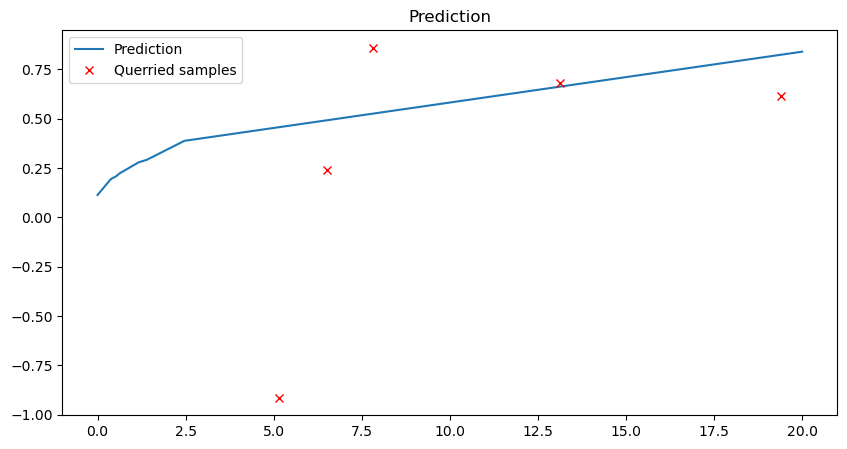

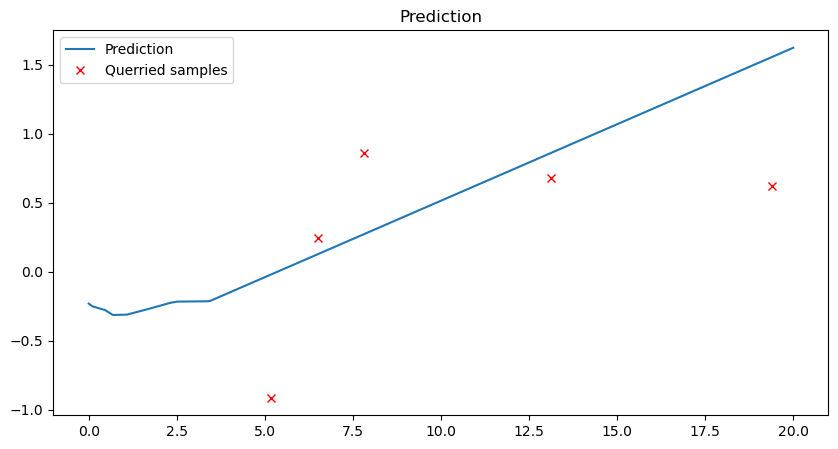

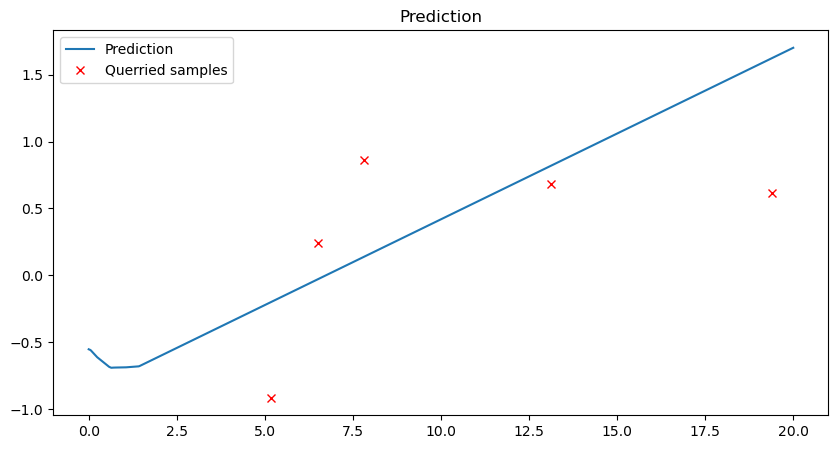

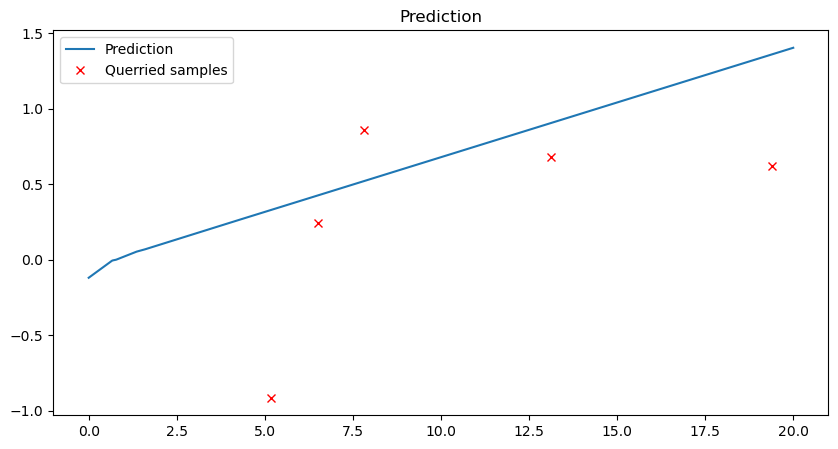

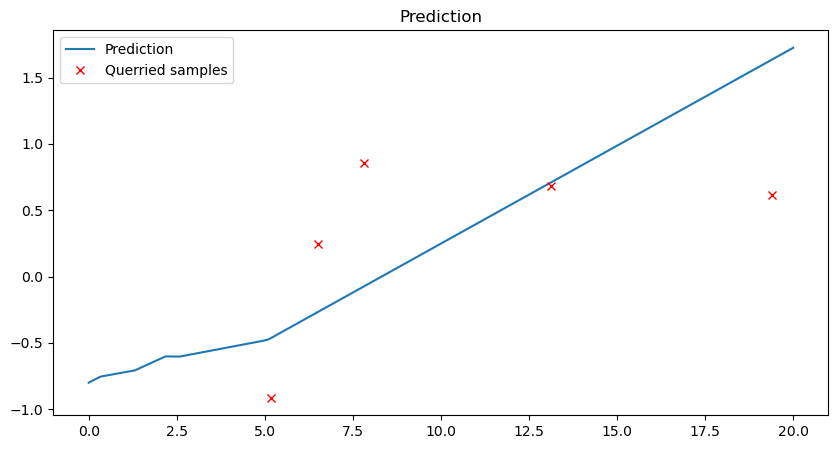

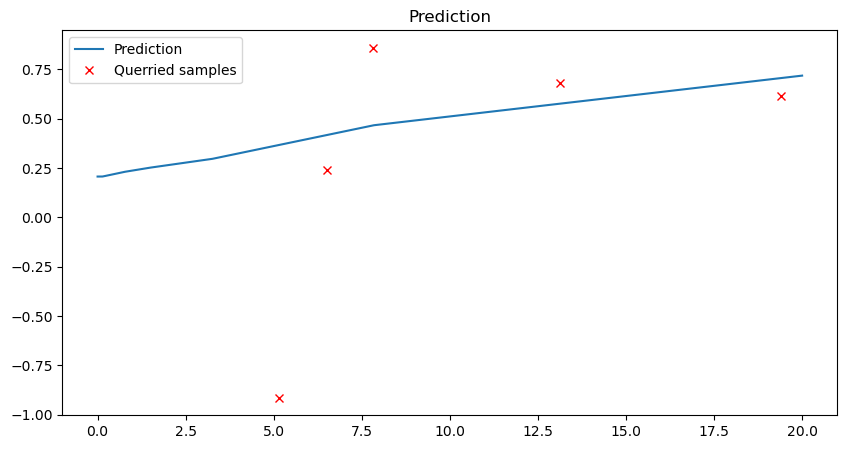

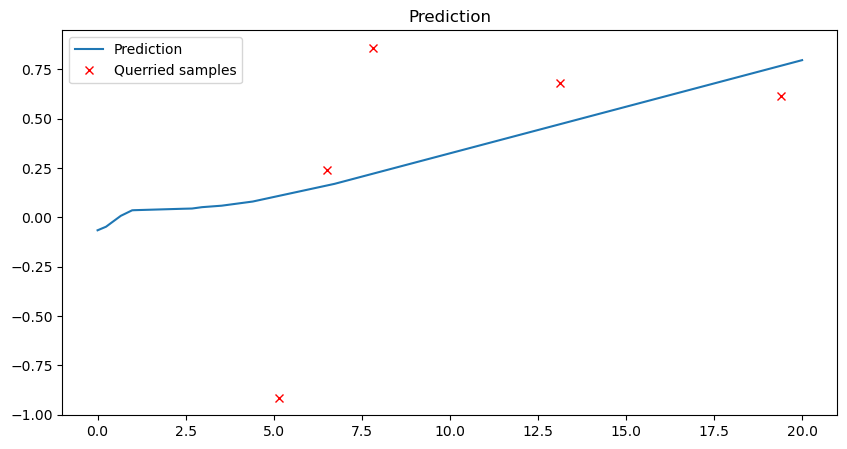

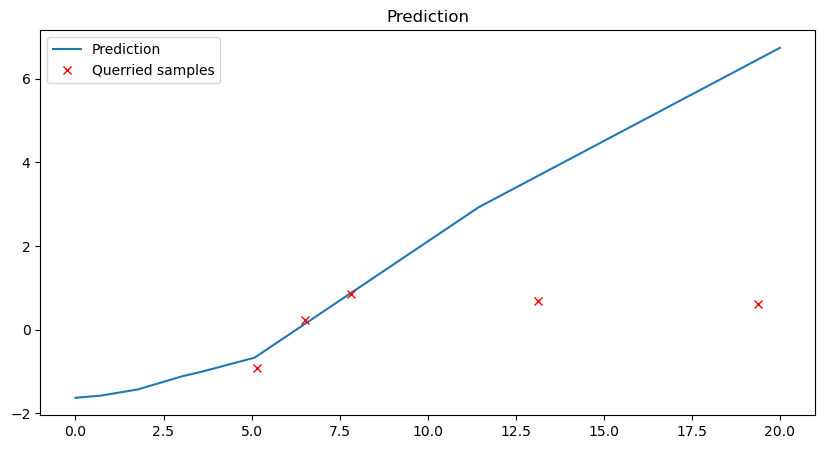

In [17]:
for ffn in learner_list:
    plotting_method(ffn, concat_unit_id(x_allowed), x_querried=x_querried, y_querried=y_querried, return_std_available=False)

Now we can initialize the `CommitteeRegressor` and take a look at the joined prediction 

Number of learners in the committee: 8


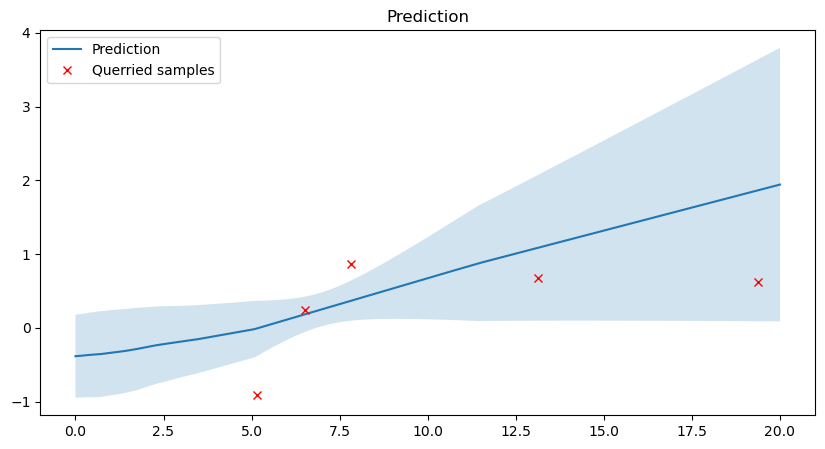

In [18]:
# initializing the Committee
committee = CommitteeRegressor(
    learner_list=learner_list,
    query_strategy=max_std_sampling
)

print(f'Number of learners in the committee: {len(committee)}')

plotting_method(committee, concat_unit_id(x_allowed), x_querried=x_querried, y_querried=y_querried)

After everything is set up, we can now start with our active learning procedure

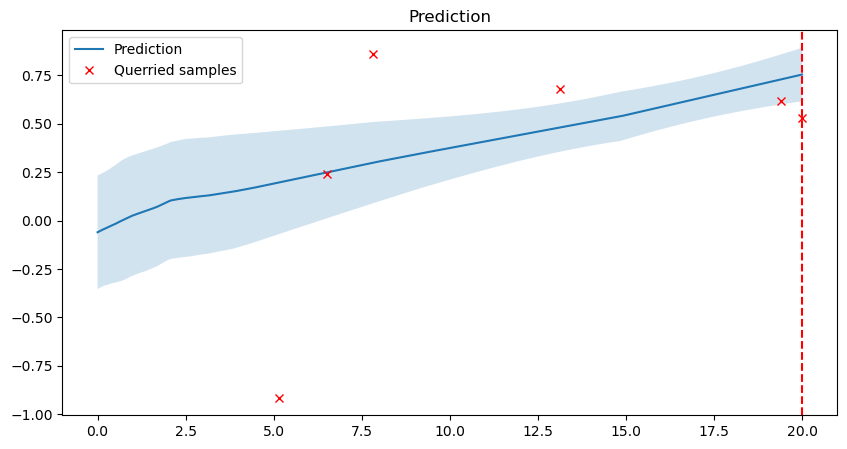

In [19]:
n_queries = 1

x_new = committee.query(concat_unit_id(x_allowed), n_instances=n_queries, random_tie_break=False)[1][:, -1:]  # get the query points from the regressor which are expected to be the most informative
y_new = ground_truth(x_new)

committee.teach(concat_unit_id(x_new), y_new)  # fit the model with the query points

x_querried = np.concatenate((x_querried, x_new))
y_querried = np.concatenate((y_querried, y_new))

# get the predicted response and the standard deviation
plotting_method(committee, concat_unit_id(x_allowed), x_new=x_new, x_querried=x_querried, y_querried=y_querried)

How does it look like? Let's give it some more iterations!

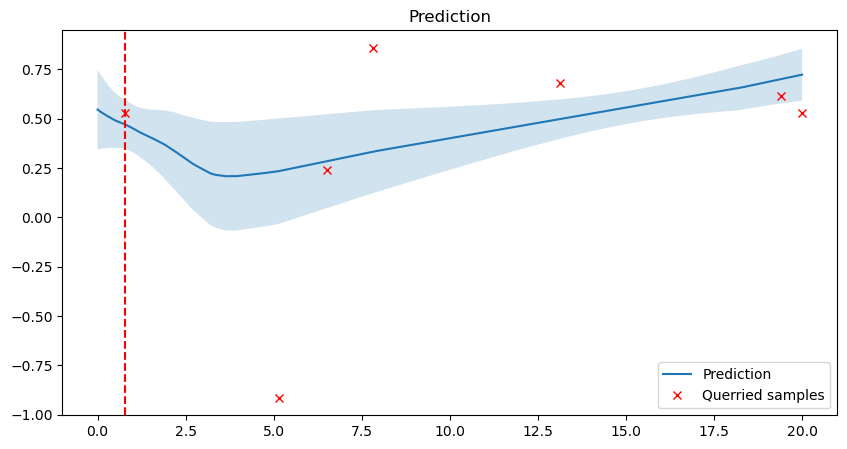

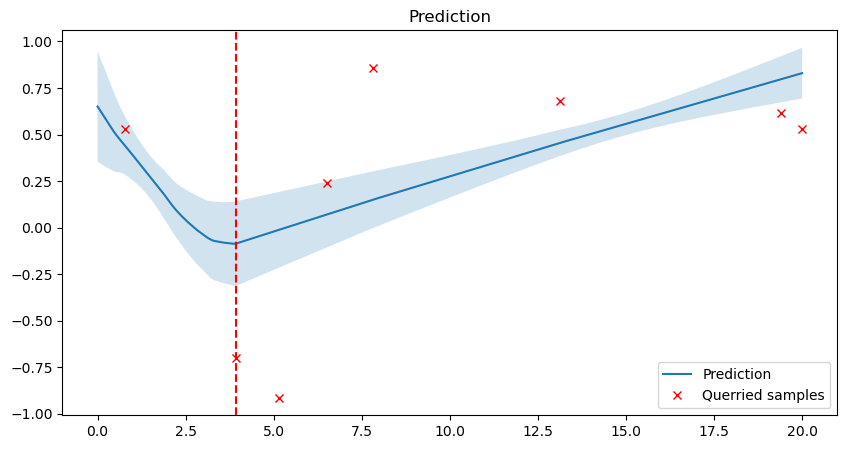

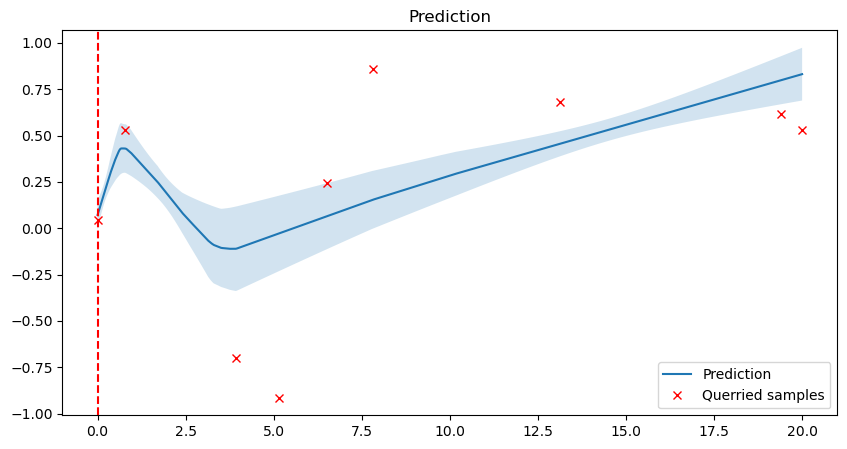

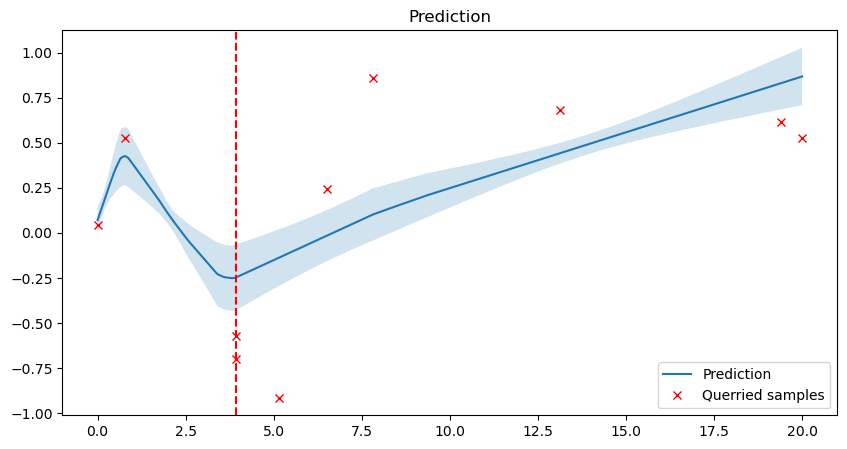

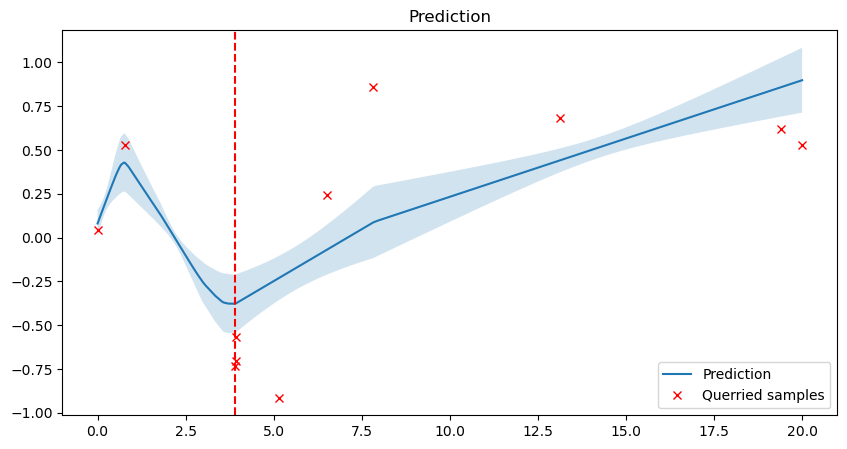

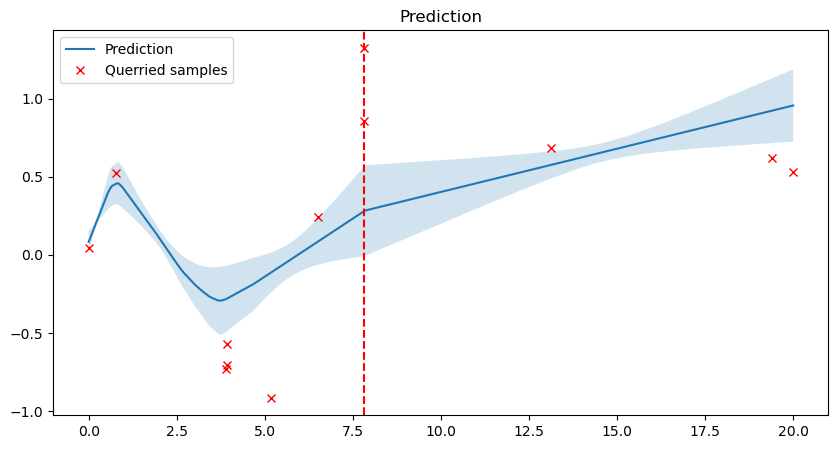

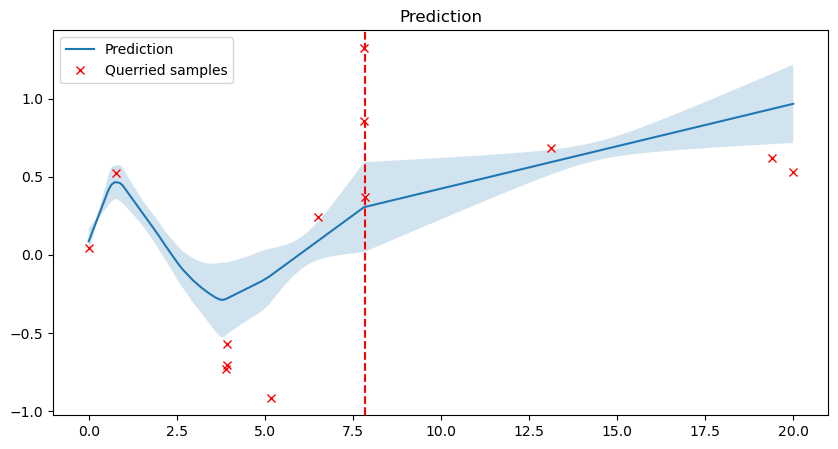

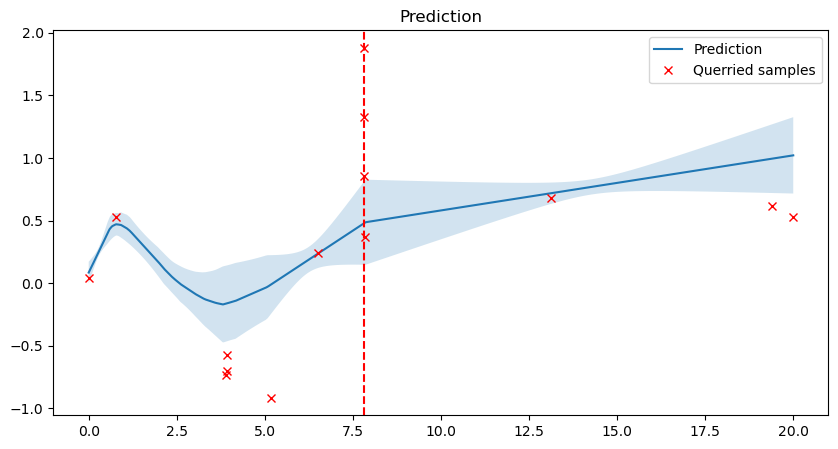

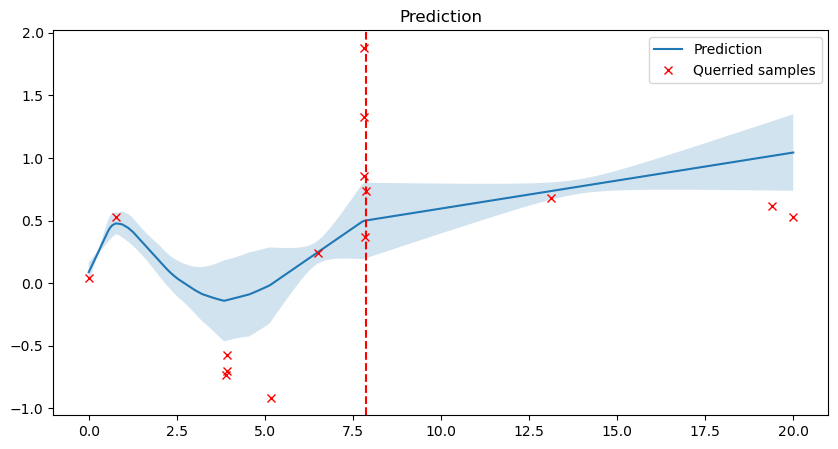

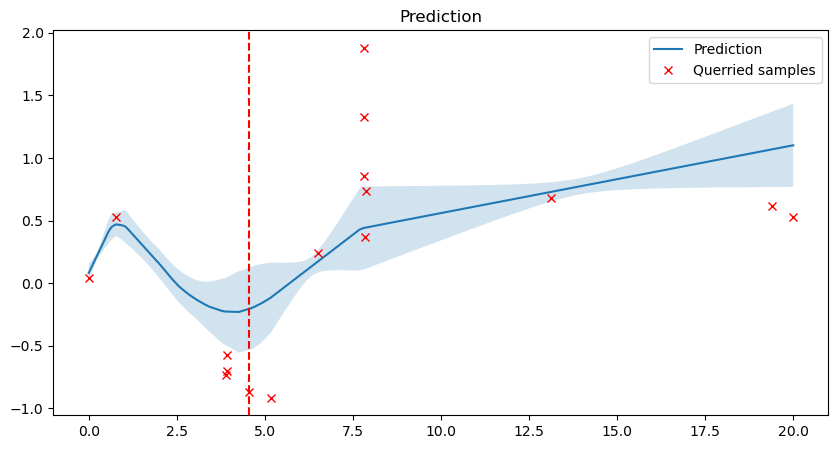

In [20]:
iterations = 10

for _ in range(iterations):
    x_new = committee.query(concat_unit_id(x_allowed), n_instances=n_queries, random_tie_break=False)[1][:, -1:]  # get the query points from the regressor which are expected to be the most informative
    y_new = ground_truth(x_new)

    committee.teach(concat_unit_id(x_new), y_new)  # fit the model with the query points

    x_querried = np.concatenate((x_querried, x_new))
    y_querried = np.concatenate((y_querried, y_new))

    # get the predicted response and the standard deviation
    plotting_method(committee, concat_unit_id(x_allowed), x_new=x_new, x_querried=x_querried, y_querried=y_querried)

## Active Learning on the 2AFC experiment

Now you are going to replace the ground truth with our 2AFC experiment.

You can basically repeat all the previous steps from the previous section.

In [21]:
from resources.synthetic import generate_dataset, experimental_unit, normal_ground_truth, noise

In [22]:
# define the dataset parameters

# number of models in the ensemble
n_ensemble = 8

# number of experimental units
n_units = 100

# number of observations per experimental unit
n_conditions = 10

# number of repetitions per condition
n_repetitions = 1

# amount of noise which we are going to add to the data
noise_level = 0.

# relative amount of train vs test samples
train_ratio = 0.8

## Congratulations!

You've finished the introductory tutorial to active learning and the key components of modAL!

Let's explore the key features of modAL even more in the next tutorial.